# Bay Area Airbnb Review Classification
### Capstone Part 2: Semi-Supervised Learning
Lauren Mitchell 2022

#### Project Objective 
The objective of this project is to take Airbnb reviews from available web datasets and perform Natural Language Processing on the text of the reviews to evaluate them on sentiment analysis and then cluster them based on possible issues with the Airbnbs. 


#### Notebook Objective
This notebook tackles the third step which includes breaking apart the data for semi-supervised learning, cleaning the data and tokenizing the sentences and then testing out a few classification models. 

The output of this notebook is the final dataframe with review sentences and binary columns for inclusion/exclusion in different categories

Notebook Outline

Section 1: Data Import / Cleaning
3. Import the labeled files
4. Change the y variable data type to categorical
5. Build the tokenizer to process the text
6. Train test split

Section 2: Vectorization 
7. Bag of Words Count Vectorizer
8. TF-IDF Vectorizer

Section 3: Modeling 
9. Logistic Regression
10. KNN
11. Decision Tree
12. Random Forrest
11. Testing out Binary Classification

Section 4: Testing
12. Testing on the test set using the remainder

Section 5: Building the final data frame
13. Organizing the labeled data
14. Predicting on the unlabeled Data

#### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for processing text
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from nltk.corpus import stopwords
from nltk.stem import *
import nltk
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
import re
import string
print(string.punctuation)

#for modeling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# classification report
from sklearn.metrics import classification_report

pd.set_option('display.max_colwidth', None)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Section 1: Data Import / Cleaning

#### Tables for Semi-Supervised Learning

train_1000
 - a randomly sampled subset of 1000 rows of negative sentences
 - SHAPE: 1000 rows 

test_500
- a randomly sampled subset of 500 rows of negative sentences
- SHAPE: 500 rows

test_500
- a randomly sampled subset of 500 rows of negative sentences.
- SHAPE: 500 rows

unsupervised_data_28334
- the remaining negative sentences. These will not be labeled.
- SHAPE: 

In [ ]:
# importing files from Phase 1.
from google.colab import files
uploaded = files.upload()

Saving validate_500.tsv to validate_500.tsv
Saving test_500.tsv to test_500.tsv
Saving train_1000.tsv to train_1000.tsv
Saving unsupervised_data_25918.csv to unsupervised_data_25918.csv


In [ ]:
train_1000 = pd.read_csv('train_1000.tsv', sep ='\t')
test_500 = pd.read_csv('test_500.tsv', sep ='\t')
validation_500 = pd.read_csv('validate_500.tsv', sep ='\t')
unsupervised_data_25918 = pd.read_csv('unsupervised_data_25918.csv', sep ='\t')

### Setting category columns (y) as categorical

In [ ]:
train_1000['category'] = train_1000['category'].astype("category")
validation_500['category'] = validation_500['category'].astype("category")
test_500['category'] = test_500['category'].astype("category")

#### Examining the distribution of the y categories in the dataframes

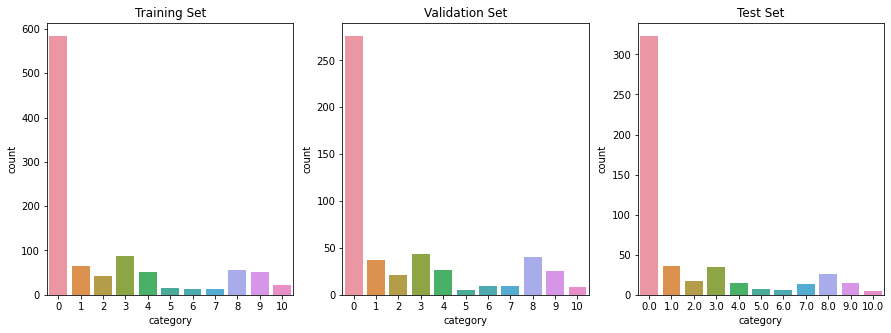

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize = (15,5))

ax1 = sns.countplot(x="category", data=train_1000, ax=axs[0])
ax2 = sns.countplot(x="category", data=validation_500, ax=axs[1])
ax3 = sns.countplot(x="category", data=test_500, ax=axs[2]);

ax1.title.set_text('Training Set')
ax2.title.set_text('Validation Set')
ax3.title.set_text('Test Set')

There is a clear class impalence that will need to be addressed. Class 0 refers to no issue with the airbnb.

# Labeled Classes

0. No issue
1. Broken or Missing
2. Negative Experience with Host
3. General Dissatisfaction 
4. Lack of Privacy or Safety
5. Not as Advertised
6. Issues with Cost or Fees
7. Uncomfortable temperature 
8. Not clean
9. Noise Issues
10. Parking Issues

### Splitting Train and Test Data

In [ ]:
X_train = train_1000['sentence']
y_train = train_1000['category']

print(f'the training set size has {X_train.shape} reviews and {y_train.shape} categorized answers')

X_validation = validation_500['sentence']
y_validation = validation_500['category']

print(f'the validation set size has {X_validation.shape} reviews and {y_validation.shape} categorized answers')

X_test = test_500['sentence']
y_test = test_500['category']

print(f'the test set size has {X_test.shape} reviews and {y_test.shape} categorized answers')

the training set size has (1000,) reviews and (1000,) categorized answers
the validation set size has (500,) reviews and (500,) categorized answers
the test set size has (500,) reviews and (500,) categorized answers


In [ ]:
y_test[y_test.isna()]

In [ ]:
# Fixing a data import issue
y_test[314] = 1
y_test[358] = 8

In [ ]:
X_train

0                              If you are a light sleeper or are really bothered by the noise, I wouldn’t recommend.
1                                                                       Overall, a very strange and shady situation.
2                                                          My family was there to help my cousin move into Berkeley.
3      We were only here for a few days while we moved out of state, so we did not do any exploring around the area.
4                                                                             Sierra siempre muy amable y servicial.
                                                           ...                                                      
995                                                                                                 Little terriers.
996                                                                           (Moldy dishes, dirty appliances, etc.)
997                                                Maison gigant

In [ ]:
y_train

0      8
1      4
2      0
3      0
4      0
      ..
995    0
996    8
997    0
998    0
999    3
Name: category, Length: 1000, dtype: category
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

# Section 2: Vectorization

### Cleaning text columns, Building tokenizer 

In [ ]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

stemmer = PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Testing out Tokenizer Function on a single sentence

In [ ]:
train_1000['sentence'][11]

'I mostly took Uber to restaurants, which worked fine.'

In [ ]:
my_tokenizer(train_1000['sentence'][11])

['mostli', 'took', 'uber', 'restaur', 'work', 'fine']

### Bag of Words Count Vectorizer

the bag of words document-term matrix must be trained on the training data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# 1. Instantiate
bagofwords = CountVectorizer(stop_words="english",
                             ngram_range=(1, 3),
                             tokenizer = my_tokenizer)

# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_transformed = bagofwords.transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'wh

In [ ]:
#transforming the validation set
X_validation_transformed = bagofwords.transform(X_validation)
#transforming the test set
X_test_transformed = bagofwords.transform(X_test)


#### A look at the top bigrams

In [ ]:
words = bagofwords.get_feature_names()

word_count = X_train_transformed.toarray().sum(axis=0)
count_df = pd.DataFrame({'token': words, 'count': word_count})

count_df[count_df['token'].str.split(' ').apply(len) == 2].sort_values('count', ascending=False).head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,token,count
9890,san francisco,18
12429,walk distanc,10
8544,place stay,8
4733,great locat,8
1065,bart station,8
4742,great place,7
5170,host cancel,6
2816,day arriv,6
1699,cancel reserv,6
6480,locat close,6


# Section 3: Modeling

## Model 1: Logistic Regression Classifier Model 

In [ ]:
# The C_values to try
C_vals = [0.00001, 0.0001, 0.001, 1, 10]

# Empty lists to append train and test accuracy scores to 
train_acc_logreg = []
val_acc_logreg = []

# Loop through the different C values
for C in C_vals:

    # Instantiate the model
    logreg = LogisticRegression(C = C, max_iter = 1000)

    # Fit the model 
    logreg.fit(X_train_transformed, y_train)

    # Score the model 
    train_acc_logreg.append(logreg.score(X_train_transformed, y_train))
    val_acc_logreg.append(logreg.score(X_validation_transformed, y_validation))

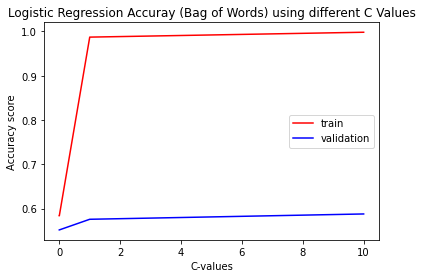

In [ ]:
# visualize accuracies for different C-values
plt.figure()
plt.title('Logistic Regression Accuray (Bag of Words) using different C Values')
plt.plot(C_vals, train_acc_logreg, c='red', label='train')
plt.plot(C_vals, val_acc_logreg, c='blue', label='validation')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

60% accuracy is not bad for classifying text reviews! Let's see how each induvidual category is performing.

#### Classification Matrix

In [ ]:
#making predictions
y_pred = logreg.predict(X_validation_transformed)

#evaluating how good those predicitons were
print(classification_report(y_validation, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.59      0.97      0.74       276
           1       0.80      0.11      0.19        37
           2       0.00      0.00      0.00        21
           3       0.27      0.09      0.14        44
           4       0.50      0.15      0.24        26
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         9
           7       0.50      0.11      0.18         9
           8       0.86      0.15      0.26        40
           9       0.67      0.24      0.35        25
          10       0.50      0.25      0.33         8

    accuracy                           0.59       500
   macro avg       0.43      0.19      0.22       500
weighted avg       0.56      0.59      0.49       500



In [ ]:
#Making a model evaluation dataframe
model_evaluation = pd.DataFrame({'Model': 'Model 1: Logreg with C of 10', 'Val Accuracy': 0.59}, index=[0])
model_evaluation

,Model,Val Accuracy
0,Model 1: Logreg with C of 10,0.59


- precision is the classifiers exactness, “for all instances classified as this class, what percent was correct?”

- recall is the measure of completeness, “for all instances that were actually this class, what percent was classified correctly?”

- F1 score is the harmonic mean between the two.

In the case of this project, it is easy for the model to just predict 0 becuase it is the dominant class. I would like to increase the recall for some of the smaller classes. 

**observations:**
- support is how many rows were actually in that class. As we can see for a few classes nothing was given that label. 
- I will try to add class weights and see how it improves.

## Model 2: Logistic Regression with Class Weights

wj=n_samples / (n_classes * n_samplesj)

In [ ]:
# finding class weights
class_count = 1000 / (train_1000['category'].value_counts()*11)

class_count

0     0.155666
3     1.044932
1     1.377410
8     1.623377
4     1.748252
9     1.748252
2     2.164502
10    4.329004
5     6.060606
7     6.993007
6     7.575758
Name: category, dtype: float64

In [ ]:
class_weights = {0:0.155666,
                 1:1.377410,
                 2:2.164502,
                 3:1.044932,
                 4:1.748252,
                 5:6.060606,
                 6:7.575758,
                 7:6.993007,
                 8:1.623377,
                 9:1.748252,
                 10:4.329004}

In [ ]:
# Instantiate the model
logreg = LogisticRegression(C = 10, max_iter = 1000, class_weight=class_weights)

# Fit the model 
logreg.fit(X_train_transformed, y_train)

# Score the model 
print(logreg.score(X_train_transformed, y_train))
print(logreg.score(X_validation_transformed, y_validation))

0.995
0.594


In [ ]:
#making predictions
y_pred = logreg.predict(X_validation_transformed)

#evaluating how good those predicitons were
print(classification_report(y_validation, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.62      0.92      0.74       276
           1       0.83      0.14      0.23        37
           2       0.50      0.05      0.09        21
           3       0.26      0.23      0.24        44
           4       0.50      0.19      0.28        26
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         9
           7       0.50      0.11      0.18         9
           8       0.75      0.15      0.25        40
           9       0.73      0.32      0.44        25
          10       0.60      0.75      0.67         8

    accuracy                           0.59       500
   macro avg       0.48      0.26      0.28       500
weighted avg       0.59      0.59      0.52       500



adding class weights didn't do much

In [ ]:
m2 = {'Model': 'Model 2: Logreg C = 10 with class weights', 'Accuracy': 0.59}
model_evaluation = model_evaluation.append(m2, ignore_index = True)
model_evaluation

,Model,Val Accuracy,Accuracy
0,Model 1: Logreg with C of 10,0.59,NaN
1,Model 2: Logreg C = 10 with class weights,NaN,0.59


## Model 3: KNN

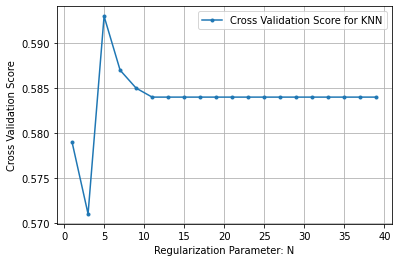

The best model has N =  5


In [ ]:
cross_validation_scores_knn = []

neighbors = np.array(range(1,40,2))

#Do some cross validation
for n in neighbors:
    KNN_model = KNeighborsClassifier(n_neighbors = n)
    cv_score_knn = np.mean(cross_val_score(KNN_model, X_train_transformed, y_train, cv = 4))
    cross_validation_scores_knn.append(cv_score_knn)

plt.figure()
plt.plot(neighbors, cross_validation_scores_knn,label="Cross Validation Score for KNN",marker='.')
plt.legend()
plt.xlabel('Regularization Parameter: N')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores_knn).argmax()

print("The best model has N = ",neighbors[which_max])

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train_transformed, y_train)
print("KNN: ", round(knn_model.score(X_validation_transformed,y_validation),2))

KNN:  0.55


In [ ]:
m3 = {'Model': 'Model 3: KNN, k = 5', 'Accuracy': 0.55}
model_evaluation = model_evaluation.append(m3, ignore_index = True)
model_evaluation

,Model,Val Accuracy,Accuracy
0,Model 1: Logreg with C of 10,0.59,NaN
1,Model 2: Logreg C = 10 with class weights,NaN,0.59
2,"Model 3: KNN, k = 5",NaN,0.55


## Model 4: KNN with Ensemble Learning

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Empty lists to append train and test accuracy scores to 
train_acc_knn_ensemble = []
val_acc__knn_ensemble = []

list_of_neighbors = [1,3,5,7,9,11]

for n in list_of_neighbors:

  # Fit several estimators
  ensemble_of_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors=n), n_estimators=20, random_state=2)
  ensemble_of_KNN.fit(X_train_transformed, y_train)

  # Score the model 
  train_acc_knn_ensemble.append(ensemble_of_KNN.score(X_train_transformed, y_train))
  val_acc__knn_ensemble.append(ensemble_of_KNN.score(X_validation_transformed, y_validation))

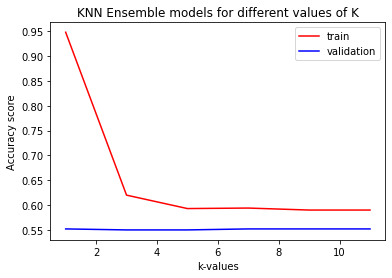

In [ ]:
# visualize accuracies for different C-values
plt.figure()
plt.title('KNN Ensemble models for different values of K')
plt.plot(list_of_neighbors, train_acc_knn_ensemble, c='red', label='train')
plt.plot(list_of_neighbors, val_acc__knn_ensemble, c='blue', label='validation')
plt.xlabel('k-values')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [ ]:
print(f"The classification accuracy of our model on the validation set is: {ensemble_of_KNN.score(X_validation_transformed,y_validation)}\n\n")

The classification accuracy of our model on the validation set is: 0.552




In [ ]:
m4 = {'Model': 'Model 4: KNN, Ensemble Learning', 'Accuracy': 0.55}
model_evaluation = model_evaluation.append(m4, ignore_index = True)
model_evaluation

,Model,Val Accuracy,Accuracy
0,Model 1: Logreg with C of 10,0.59,NaN
1,Model 2: Logreg C = 10 with class weights,NaN,0.59
2,"Model 3: KNN, k = 5",NaN,0.55
3,"Model 4: KNN, Ensemble Learning",NaN,0.55


## Model 5: Decision Tree

In [ ]:
# fitting the DT
DT_model_one = DecisionTreeClassifier()
DT_model_one.fit(X_train_transformed, y_train)

# Getting the score
print(f"The classification accuracy is: {DT_model_one.score(X_train_transformed, y_train)}")
print(f"The validaiton accuracy is: {DT_model_one.score(X_validation_transformed, y_validation)}")

The classification accuracy is: 0.998
The validaiton accuracy is: 0.584


In [ ]:
m5 = {'Model': 'Decision Tree', 'Accuracy': 0.576}
model_evaluation = model_evaluation.append(m5, ignore_index = True)
model_evaluation

,Model,Val Accuracy,Accuracy
0,Model 1: Logreg with C of 10,0.59,NaN
1,Model 2: Logreg C = 10 with class weights,NaN,0.590
2,"Model 3: KNN, k = 5",NaN,0.550
3,"Model 4: KNN, Ensemble Learning",NaN,0.550
4,Decision Tree,NaN,0.576


## Model 6: Random Forrest 

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train_transformed, y_train)

# Getting the score
print(f"The classification accuracy is: {random_forest.score(X_train_transformed, y_train)}")
print(f"The validaiton accuracy is: {random_forest.score(X_validation_transformed, y_validation)}")

The classification accuracy is: 0.994
The validaiton accuracy is: 0.58


In [ ]:
m6 = {'Model': 'Random Forrest', 'Accuracy': 0.578}
model_evaluation = model_evaluation.append(m6, ignore_index = True)
model_evaluation

,Model,Val Accuracy,Accuracy
0,Model 1: Logreg with C of 10,0.59,NaN
1,Model 2: Logreg C = 10 with class weights,NaN,0.590
2,"Model 3: KNN, k = 5",NaN,0.550
3,"Model 4: KNN, Ensemble Learning",NaN,0.550
4,Decision Tree,NaN,0.576
5,Random Forrest,NaN,0.578


# New Approach: Binary Classification Problem

Would looking at this as a binary classification problem increase accuracy? A sentence can have more than one problem tag so that would not be an issue if a sentence is flagged for mutliple classes. 

## Looking at one variable instead of 11...

I will test this method with the variable # which is related to noise compliants. A few common words are always used which makes me think this one would be "easy" for the alogorithm.


In [ ]:
# Creating a mapper to change the dependent variable from a multi-class problem to a binary classification problem.
cat_9_mapper = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:1, 10:0}

y_train_category9 = y_train.replace(cat_9_mapper)
y_val_category9 = y_validation.replace(cat_9_mapper)

y_train_category9

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: category, Length: 1000, dtype: int64

In [ ]:
# The C_values to try
C_vals = [0.00001, 0.0001, 0.001, 1, 10]

# Empty lists to append train and test accuracy scores to 
train_acc_logreg = []
val_acc_logreg = []

# Loop through the different C values
for C in C_vals:

    # Instantiate the model
    logreg = LogisticRegression(C = C)

    # Fit the model 
    logreg.fit(X_train_transformed, y_train_category9)

    # Score the model 
    train_acc_logreg.append(logreg.score(X_train_transformed, y_train_category9))
    val_acc_logreg.append(logreg.score(X_validation_transformed, y_val_category9))

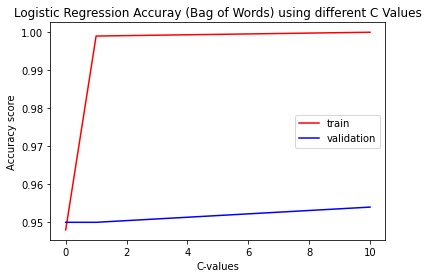

In [ ]:
# visualize accuracies for different K-values
plt.figure()
plt.title('Logistic Regression Accuray (Bag of Words) using different C Values')
plt.plot(C_vals, train_acc_logreg, c='red', label='train')
plt.plot(C_vals, val_acc_logreg, c='blue', label='validation')
plt.xlabel('C-values')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [ ]:
    # Instantiate the model
    logreg_class9 = LogisticRegression(C = 10)

    # Fit the model 
    logreg_class9.fit(X_train_transformed, y_train_category9)

    # Score the model 
    print(logreg_class9.score(X_train_transformed, y_train_category9))
    print(logreg_class9.score(X_validation_transformed, y_val_category9))

1.0
0.954


The accuracy score has greatly improved. However, is this because the model is always guessing 0? 

In [ ]:
#making predictions
y_pred = logreg_class9.predict(X_validation_transformed)

#evaluating how good those predicitons were
print(classification_report(y_val_category9, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       475
           1       1.00      0.08      0.15        25

    accuracy                           0.95       500
   macro avg       0.98      0.54      0.56       500
weighted avg       0.96      0.95      0.93       500



## Including Class weights

In [ ]:
    # Instantiate the model
    logreg_class9 = LogisticRegression(C = 10, class_weight = {0:0.0958, 1:1.749})

    # Fit the model 
    logreg_class9.fit(X_train_transformed, y_train_category9)

    # Score the model 
    print(logreg_class9.score(X_train_transformed, y_train_category9))
    print(logreg_class9.score(X_validation_transformed, y_val_category9))

1.0
0.956


In [ ]:
#making predictions
y_pred = logreg_class9.predict(X_validation_transformed)

#evaluating how good those predicitons were
print(classification_report(y_val_category9, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       475
           1       0.71      0.20      0.31        25

    accuracy                           0.96       500
   macro avg       0.84      0.60      0.64       500
weighted avg       0.95      0.96      0.94       500



Adding class weights improved recall! Compared to the logreg for all classes precision has improved from 67% to 71%, reacall has decreased from 24% to 20%. The f1 score decreased from 35% to 31%. So while this appears appealing because of the high overall accuracy, it is misleading. 

## Model Evaluation

it appears the best model is Logistic Regression with class weights, with an accuracy of 59%. 

# Section 4: Testing the Chosen Model

## Using the Train + Validation (Remainder) to train the model, comparing against the test set

You can't concat sparce matrixes so we will need to make a new merged dataframe of all training data including the validation data.

In [ ]:
remainder_1500 = pd.concat([train_1000[['category','sentence',"unique_review_code"]], validation_500[['category','sentence',"unique_review_code"]]], axis = 0)
remainder_1500.shape

(1500, 3)

In [ ]:
X_remainder = remainder_1500['sentence']
y_remainder = remainder_1500['category']

## Applying Bag of Words on the Remainder

In [ ]:
# 1. Instantiate
bagofwords = CountVectorizer(stop_words="english",
                             ngram_range=(1, 3))

# 2. Fit
bagofwords.fit(X_remainder)

# 3. Transform
X_remainder_transformed = bagofwords.transform(X_remainder)
X_remainder_transformed

<1500x18544 sparse matrix of type '<class 'numpy.int64'>'
	with 25809 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_transformed = bagofwords.transform(X_test)
X_test_transformed

<500x18544 sparse matrix of type '<class 'numpy.int64'>'
	with 2985 stored elements in Compressed Sparse Row format>

### Final Test Accuracy

In [ ]:
class_weights

{0: 0.155666,
 1: 1.37741,
 2: 2.164502,
 3: 1.044932,
 4: 1.748252,
 5: 6.060606,
 6: 7.575758,
 7: 6.993007,
 8: 1.623377,
 9: 1.748252,
 10: 4.329004}

In [ ]:
# Instantiate the model
logreg_test = LogisticRegression(C = 10, max_iter = 1000, class_weight=class_weights)

# Fit the model 
logreg_test.fit(X_remainder_transformed, y_remainder)

# Score the model 
print(logreg_test.score(X_remainder_transformed, y_remainder))
print(logreg_test.score(X_test_transformed, y_test))

0.996
0.678


## The model is performing better on the test set than the validation set.

## It improved from 59% to 67.8%.
This could be because we are training the model with more data. 

# Section 5: Building the final Dataframe

first using the data that was labeled

In [ ]:
final_train = train_1000[['unique_review_code','category','sentence']]
final_val = validation_500[['unique_review_code','category','sentence']]
final_test = test_500[['unique_review_code','category','sentence']]

In [ ]:
final_labeled_df = pd.concat([final_train, final_val, final_test], axis = 0)
final_labeled_df.category = final_labeled_df.category.astype(int)
print(final_labeled_df.shape)
final_labeled_df.head()

(2000, 3)


,unique_review_code,category,sentence
0,33437,8,"If you are a light sleeper or are really bothered by the noise, I wouldn’t recommend."
1,11914,4,"Overall, a very strange and shady situation."
2,73115,0,My family was there to help my cousin move into Berkeley.
3,70385,0,"We were only here for a few days while we moved out of state, so we did not do any exploring around the area."
4,53402,0,Sierra siempre muy amable y servicial.


# Pedicting on Unseen Data

In [ ]:
unsupervised_data_25918 = unsupervised_data_25918[['unique_review_code', 'sentence']]
unsupervised_data_25918.head()

,unique_review_code,sentence
0,11,"Clean, but outdated place with cheap furniture falling apart."
1,11,It is located in a sketchy area 4 blocks away from the Barc metro station.
2,11,"If You are a light sleeper, that’s no a place to be."
3,11,"You will be hearing the neighbors (starting at 6 am), the steps on top your bedroom and at 4 am maybe a dog playing with a toy on top your bedroom (vs. haunted activities)"
4,22,Homely feel


In [ ]:
X_unsupervised = unsupervised_data_25918['sentence']

In [ ]:
print(unsupervised_data_25918.shape)

(25918, 2)


As we can see above, we have the review index and the sentence for the unsupervised data, but we dont yet have prediction. 

### Training the Model on all labeled data so it can make the best prediction on unseen data.

In [ ]:
# incorporating the test set in with the remainder.
all_labeled_2000 = pd.concat([remainder_1500[['category','sentence',"unique_review_code"]], test_500[['category','sentence',"unique_review_code"]]], axis = 0)
all_labeled_2000.shape

(2000, 3)

In [ ]:
X_all = all_labeled_2000['sentence']
y_all = all_labeled_2000['category']

In [ ]:
# Applying bag of words onto all labeled data

# 1. Instantiate
bagofwords = CountVectorizer(stop_words="english",
                             ngram_range=(1, 3))

# 2. Fit
bagofwords.fit(X_all)

# 3. Transform
X_all_transformed = bagofwords.transform(X_all)
X_all_transformed

<2000x23702 sparse matrix of type '<class 'numpy.int64'>'
	with 34035 stored elements in Compressed Sparse Row format>

In [ ]:
X_unsupervised_transformed = bagofwords.transform(X_unsupervised)

In [ ]:
# Instantiate the model
logreg_final = LogisticRegression(C = 10, max_iter = 1000, class_weight=class_weights)

# Fit the model 
logreg_final.fit(X_all_transformed, y_all)

# Score the model 
print(logreg_final.score(X_all_transformed, y_all))

0.9955


In [ ]:
prediction = logreg_final.predict(X_unsupervised_transformed)

In [ ]:
len(prediction)

25918

In [ ]:
unsupervised_data_25918['category'] = prediction
unsupervised_data_25918.category = unsupervised_data_25918.category.astype(int)
unsupervised_data_25918

,unique_review_code,sentence,category
0,11,"Clean, but outdated place with cheap furniture falling apart.",8
1,11,It is located in a sketchy area 4 blocks away from the Barc metro station.,4
2,11,"If You are a light sleeper, that’s no a place to be.",0
3,11,"You will be hearing the neighbors (starting at 6 am), the steps on top your bedroom and at 4 am maybe a dog playing with a toy on top your bedroom (vs. haunted activities)",9
4,22,Homely feel,0
...,...,...,...
25913,77574,It’s a shame because it has a beautiful view from the deck but you can tell they do not clean this place.,0
25914,77574,Terrible communication too.,0
25915,77574,I wasn’t given check in instructions when I booked.,0
25916,77574,"I called to ask what they were the morning I was set to check in, since he wouldn’t respond to my Airbnb messages and he didn’t even know I booked it and said I couldn’t come because it was too early, yet the app told me check in was from 8am-10am and he was really rude.",2


In [ ]:
final_labeled_df.head()

,unique_review_code,category,sentence
0,33437,8,"If you are a light sleeper or are really bothered by the noise, I wouldn’t recommend."
1,11914,4,"Overall, a very strange and shady situation."
2,73115,0,My family was there to help my cousin move into Berkeley.
3,70385,0,"We were only here for a few days while we moved out of state, so we did not do any exploring around the area."
4,53402,0,Sierra siempre muy amable y servicial.


In [ ]:
#Move last Column to First Column
new_cols = ["unique_review_code","sentence","category"]

final_labeled_df_reindex =final_labeled_df.reindex(columns=new_cols)
final_labeled_df_reindex

,unique_review_code,sentence,category
0,33437,"If you are a light sleeper or are really bothered by the noise, I wouldn’t recommend.",8
1,11914,"Overall, a very strange and shady situation.",4
2,73115,My family was there to help my cousin move into Berkeley.,0
3,70385,"We were only here for a few days while we moved out of state, so we did not do any exploring around the area.",0
4,53402,Sierra siempre muy amable y servicial.,0
...,...,...,...
495,68458,We did ask Cheong Kyle to bring us some of the items we needed (which essentially was all the basics) and he happily and promptly bought us what we needed for a basic stay.,0
496,47766,Alex was a wonderful host from start to finish!,0
497,57876,Above and beyond my expectations being a first time Airbnb user,0
498,8618,"You really can’t beat this as a home base, especially if you’re going to be using the BART during your trip, because it’s just a couple minutes’ walk from the house.",0


In [ ]:
print(unsupervised_data_25918.shape)
print(final_labeled_df_reindex.shape)

(25918, 3)
(2000, 3)


# Concatinating the final predictions

In [ ]:
final_review_categories = pd.concat((final_labeled_df_reindex, unsupervised_data_25918), axis = 0)

In [ ]:
final_review_categories.head(8)

,unique_review_code,sentence,category
0,33437,"If you are a light sleeper or are really bothered by the noise, I wouldn’t recommend.",8
1,11914,"Overall, a very strange and shady situation.",4
2,73115,My family was there to help my cousin move into Berkeley.,0
3,70385,"We were only here for a few days while we moved out of state, so we did not do any exploring around the area.",0
4,53402,Sierra siempre muy amable y servicial.,0
5,10204,This problem gets progressively worse as you walk towards the BART station from the house .,4
6,76672,I’ve never been so terrified in my life!,4
7,36309,A small grocery store is also located 6 to 8 minutes walking distance.,0


## Verifying that the categories are correctly labeled

In [ ]:
final_review_categories.category.value_counts()

0     20461
3      2124
8      1228
1      1096
9       810
4       641
10      513
2       475
7       295
6       192
5        83
Name: category, dtype: int64

In [ ]:
final_review_categories.query('category == 9').sample(10)

,unique_review_code,sentence,category
16651,50859,"The description does say that the host lives in, if you are sensitive to noise you may hear movement upstairs but was never a huge issue during my stay.",9
3574,13938,"Which had me putting in my headphones to drown out noise from outside, as the studio is situated at the front of the house near the street, as well as noise from the side door where tenants come in and out - which is right next to the studio.",9
19134,58768,The master bedroom bed is a bit firm and you can hear the traffic from the highway and people walking by.,9
8395,28505,"We also heard movies playing, a dog barking, and people yelling and banging around / dropping things.",9
7341,25587,"The house is also next to a main road so it's hard to sleep at night with all the cars passing by if you're in one of the first two upstairs bedrooms, we were even woken up one night by hobos having a fight of some sort right across the street from the house.",9
21514,65633,"Also, with the windows open at night, the traffic noise was overwhelming.",9
12092,38401,"First, i was surprised at how noisy, particularly for a residential area, the traffic on the street abutting the residence was.",9
25826,77408,"Some street noise, but otherwise mellow.",9
23488,70603,It is tough to find parking and although you can hear people upstairs the noise is not too loud.,9
17081,52556,The only issue we had was that the downstair neighbors were very loud throughout the night.,9


Category 9 is related to noise. This looks good!

I will now download the output and move to a fresh notebook

In [ ]:
final_review_categories.to_csv('final_review_categories.csv', sep ='\t')
files.download("final_review_categories.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>